# Defining the problem :

We want to predict with a Classification model a patient health condition, Predict a patient treatment


# Importing the librairies

In [1]:
import numpy as np
import json
import requests_fhir as requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import shap
import sklearn

BASE_URL = 'https://test/fhir'

# Extracting the patients data

In [2]:
response = requests.get('{}/{}'.format(BASE_URL, 'Patient'))
print(response.status_code)

patients_df = pd.json_normalize(response.json(), record_path='entry')
patients_df = patients_df.astype({'resource.birthDate': 'datetime64[ns]'})

patients_df.head(5)

200


,fullUrl,resource.resourceType,resource.id,resource.meta.versionId,resource.meta.lastUpdated,resource.meta.source,resource.text.status,resource.text.div,resource.identifier,resource.gender,resource.birthDate,search.mode
0,https://test/fhir/Patient/2,Patient,2,1,2023-05-23T09:33:58.623+00:00,#TxHlcnq3KZSdg567,generated,<div>Some HTML</div>,"[{'system': 'http://example.org', 'value': '00...",female,1941-07-14,match
1,https://test/fhir/Patient/3,Patient,3,1,2023-05-23T09:33:58.623+00:00,#TxHlcnq3KZSdg567,generated,<div>Some HTML</div>,"[{'system': 'http://example.org', 'value': '00...",male,1931-10-02,match
2,https://test/fhir/Patient/4,Patient,4,1,2023-05-23T09:33:58.623+00:00,#TxHlcnq3KZSdg567,generated,<div>Some HTML</div>,"[{'system': 'http://example.org', 'value': '00...",male,1944-11-22,match
3,https://test/fhir/Patient/5,Patient,5,1,2023-05-23T09:33:58.623+00:00,#TxHlcnq3KZSdg567,generated,<div>Some HTML</div>,"[{'system': 'http://example.org', 'value': '00...",female,1939-04-13,match
4,https://test/fhir/Patient/6,Patient,6,1,2023-05-23T09:33:58.623+00:00,#TxHlcnq3KZSdg567,generated,<div>Some HTML</div>,"[{'system': 'http://example.org', 'value': '00...",male,1962-04-18,match


<p> We use the requests library so that we can make HTTP requests and the pandas librairy for tabular data manipulation </p>

In [3]:
response = requests.get('{}/{}'.format(BASE_URL, 'Patient'))
print(response.status_code)
patients_df = pd.json_normalize(response.json(), record_path='entry')[['resource.id', 'resource.gender', 'resource.birthDate']]
patients_df = patients_df.astype({'resource.birthDate': 'datetime64[ns]'})
patients_df.head(5)

200


,resource.id,resource.gender,resource.birthDate
0,2,female,1941-07-14
1,3,male,1931-10-02
2,4,male,1944-11-22
3,5,female,1939-04-13
4,6,male,1962-04-18


### Checking if there are any missing or empty value in every column in patients_df :


In [4]:
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   resource.id         742 non-null    object        
 1   resource.gender     742 non-null    object        
 2   resource.birthDate  742 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 17.5+ KB


### Getting a single patient info : 

In [5]:
patient_id = 2

response = requests.get('{}/{}/{}'.format(BASE_URL, 'Patient', patient_id))

patient_df = pd.json_normalize(response.json())[['id', 'gender', 'birthDate']]
patient_df = patient_df.astype({'birthDate': 'datetime64[ns]'})

patient_df

,id,gender,birthDate
0,2,female,1941-07-14


### Encapsulating and creating the patient function :

In [6]:
import requests_fhir as requests
from requests.exceptions import RequestException
BASE_URL = 'https://test/fhir'
def patient_data(patient_id):
    try:
        response = requests.get('{}/{}/{}'.format(BASE_URL, 'Patient', patient_id))
        if response.status_code == 200:
            # Extract patient information
            patient_info = response.json()

            # Format patient information as a string
            formatted_output = f"Patient ID: {patient_info['id']}\nGender: {patient_info['gender']}\nBirth Date: {patient_info['birthDate']}"

            # Print the formatted output
            print(formatted_output)
        else:
            print("Failed to fetch patient data. Status code:", response.status_code)
    except RequestException as e:
        print("Error:", e)


In [7]:
patient_id = 90
patient_test = patient_data(patient_id)
patient_test

Patient ID: 90
Gender: female
Birth Date: 1931-01-16


# Looking at snomed.csv

In [8]:
snomed = pd.read_csv("data/snomed.csv")
snomed = snomed.astype({'code': 'string'})
snomed.info()
snomed.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  31 non-null     object
 1   label   31 non-null     object
 2   URL     31 non-null     object
 3   code    31 non-null     string
dtypes: object(3), string(1)
memory usage: 1.1+ KB


,source,label,URL,code
0,baseline_data,smoker,http://purl.bioontology.org/ontology/SNOMEDCT/...,77176002
1,blood_data,systolic,http://purl.bioontology.org/ontology/SNOMEDCT/...,271649006
2,blood_data,diastolic,http://purl.bioontology.org/ontology/SNOMEDCT/...,271650006
3,blood_data,erythrocytes,http://purl.bioontology.org/ontology/SNOMEDCT/...,397063002
4,blood_data,hemoglobin,http://purl.bioontology.org/ontology/SNOMEDCT/...,250220000


### Function for Snomed CSV file :

In [9]:
def read_and_process_snomed_csv(file_path):
    # Read the CSV file
    snomed = pd.read_csv(file_path)
    # Convert 'code' column to string type
    snomed = snomed.astype({'code': 'string'})
    # Display info and the first 5 rows
    return snomed

### Testing the function snomed

In [10]:
file_path = "data/snomed.csv"
snomed_df = read_and_process_snomed_csv(file_path)

# Loading Treatment data CSV file


In [11]:
treat = pd.read_csv("data/treat_data.csv")
treat['treat_start_date'] = pd.to_datetime(treat['treat_start_date'])
treat['record_id'] = treat['record_id'].astype(str)
#treat.info()
#treat

## Merging patient and treatment data

In [12]:
merged_df = pd.merge(treat, patients_df, left_on='record_id', right_on='resource.id', how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3902 entries, 0 to 3901
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          3902 non-null   int64         
 1   record_id           3902 non-null   object        
 2   treat_start_date    3902 non-null   datetime64[ns]
 3   cvscore             3902 non-null   float64       
 4   aspirin             3349 non-null   float64       
 5   clopridrogel        3902 non-null   int64         
 6   anticlot            3902 non-null   int64         
 7   ezetimibe           3902 non-null   int64         
 8   statins             3902 non-null   int64         
 9   ace                 1964 non-null   float64       
 10  resource.id         3902 non-null   object        
 11  resource.gender     3902 non-null   object        
 12  resource.birthDate  3902 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(5), obje

In [13]:
m = merged_df.drop('cvscore', axis = 1)
m = merged_df.drop('treat_start_date', axis = 1)
m = merged_df.drop('resource.gender', axis = 1)
m

,Unnamed: 0,record_id,treat_start_date,cvscore,aspirin,clopridrogel,anticlot,ezetimibe,statins,ace,resource.id,resource.birthDate
0,7,2,2005-06-10,0.038796,1.0,0,0,0,1,1.0,2,1941-07-14
1,8,2,2006-09-12,0.029312,1.0,0,0,0,1,1.0,2,1941-07-14
2,9,2,2007-10-15,0.078749,1.0,0,0,0,1,NaN,2,1941-07-14
3,10,2,2008-09-22,0.074852,1.0,0,0,0,1,NaN,2,1941-07-14
4,11,2,2009-09-21,0.047559,1.0,0,0,0,1,NaN,2,1941-07-14
...,...,...,...,...,...,...,...,...,...,...,...,...
3897,8169,1592,2007-06-09,0.069686,NaN,0,0,0,1,0.0,1592,1942-04-06
3898,8170,1593,2005-11-07,0.116344,1.0,0,0,0,1,1.0,1593,1950-02-08
3899,8171,1594,2005-10-03,0.143398,1.0,0,0,0,1,0.0,1594,1928-12-07
3900,8172,1595,2005-06-02,0.186276,1.0,0,0,0,1,1.0,1595,1942-08-27


### Function for loading Treatment file :

In [14]:
def treatment_file(file_path):
    # Read the CSV file
    treat = pd.read_csv(file_path)
    # Convert 'treat_start_date' column to datetime
    treat['treat_start_date'] = pd.to_datetime(treat['treat_start_date'])
    # Convert 'record_id' column to string type
    treat['record_id'] = treat['record_id'].astype(str)
    # Display info and the DataFrame
    print(treat.info())
    print(treat)
    return treat


### Testing the Treatment function

In [15]:
file_path = "data/treat_data.csv"
treat_df = treatment_file(file_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3902 entries, 0 to 3901
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        3902 non-null   int64         
 1   record_id         3902 non-null   object        
 2   treat_start_date  3902 non-null   datetime64[ns]
 3   cvscore           3902 non-null   float64       
 4   aspirin           3349 non-null   float64       
 5   clopridrogel      3902 non-null   int64         
 6   anticlot          3902 non-null   int64         
 7   ezetimibe         3902 non-null   int64         
 8   statins           3902 non-null   int64         
 9   ace               1964 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 305.0+ KB
None
      Unnamed: 0 record_id treat_start_date   cvscore  aspirin  clopridrogel  \
0              7         2       2005-06-10  0.038796      1.0             0 

## Data Preparation

### Data seperation as X and Y :

In [16]:
y = treat_df['cvscore']
y = y.dropna()
print(y.shape)
y

(3902,)


0       0.038796
1       0.029312
2       0.078749
3       0.074852
4       0.047559
          ...   
3897    0.069686
3898    0.116344
3899    0.143398
3900    0.186276
3901    0.073243
Name: cvscore, Length: 3902, dtype: float64

### X

In [17]:
x = treat_df.drop(['cvscore','treat_start_date'], axis = 1)
x.fillna(0)
x.dropna(axis=0, how='any')
print(type(x))

<class 'pandas.core.frame.DataFrame'>


In [18]:
import pandas as pd

# Sample DataFrame with NaN values
data = {'A': [1, 2, None, 4, 5],
        'B': [None, 2, 3, None, 5]}
df = pd.DataFrame(data)

# Replace NaN values with 0 and drop rows containing NaN values
df.fillna(0, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

# Print the DataFrame after replacing NaN with 0 and dropping rows
print(df)

     A    B
0  1.0  0.0
1  2.0  2.0
2  0.0  3.0
3  4.0  0.0
4  5.0  5.0


### Function for Data separation as x and y :

In [19]:
def data_separation(treat_df):
    y = treat_df['cvscore']
    x = treat_df.drop(['cvscore','treat_start_date'], axis = 1)
    return x, y

In [20]:
t, p = data_separation(treat_df)
p

0       0.038796
1       0.029312
2       0.078749
3       0.074852
4       0.047559
          ...   
3897    0.069686
3898    0.116344
3899    0.143398
3900    0.186276
3901    0.073243
Name: cvscore, Length: 3902, dtype: float64

### Data splitting

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=100)

In [22]:
imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)

X_test = imputer.fit_transform(X_test)
X_train

array([[5.29200000e+03, 9.89000000e+02, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 7.90343075e-01],
       [6.97200000e+03, 1.32100000e+03, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 7.90343075e-01],
       [7.00000000e+00, 2.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [3.76400000e+03, 7.03000000e+02, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 7.90343075e-01],
       [5.90400000e+03, 1.12000000e+03, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.04500000e+03, 5.57000000e+02, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.90343075e-01]])

### Function for Data splitting :

In [23]:
def data_split(x, y, test_size=0.2, random_state=100):
    X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=test_size, random_state=random_state)
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.fit_transform(X_test)
    return X_train, X_test, Y_train, Y_test

### Function for Linear Regression :

In [24]:
def LR(X_train, X_test, Y_train):
    lr = LinearRegression()
    lr.fit(X_train, Y_train)
    y_lr_train_pred = lr.predict(X_train)
    y_lr_test_pred = lr.predict(X_test)
    
    return lr, y_lr_train_pred, y_lr_test_pred

In [25]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [26]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

### Function for Mean squarred error and R2 score for Linear Regression :


In [27]:
def evaluate_linear_regression(Y_train, y_lr_train_pred, Y_test, y_lr_test_pred):
    lr_train_mse = mean_squared_error(Y_train, y_lr_train_pred)
    lr_train_r2 = r2_score(Y_train, y_lr_train_pred)

    lr_test_mse = mean_squared_error(Y_test, y_lr_test_pred)
    lr_test_r2 = r2_score(Y_test, y_lr_test_pred)

    print('LR MSE (training): ', lr_train_mse)
    print('LR R2 (training): ', lr_train_r2)
    print('LR MSE (test): ', lr_test_mse)
    print('LR R2 (test): ', lr_test_r2)

    lr_result = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()

    return lr_result

In [28]:
lr_result = evaluate_linear_regression(Y_train, y_lr_train_pred, Y_test, y_lr_test_pred)
lr_result

LR MSE (training):  0.00787986695086399
LR R2 (training):  0.005605280302956039
LR MSE (test):  0.008031138511851998
LR R2 (test):  0.0069856020997636215


,0,1,2,3,4
0,Linear regression,0.00788,0.005605,0.008031,0.006986


In [29]:
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse = mean_squared_error(Y_train, y_lr_train_pred)
lr_train_r2 = r2_score(Y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(Y_test, y_lr_test_pred)
lr_test_r2 = r2_score(Y_test, y_lr_test_pred)

In [30]:
print('LR MSE (training): ', lr_train_mse)
print('LR R2 (training): ', lr_train_r2)
print('LR MSE (test): ', lr_test_mse)
print('LR R2 (test): ', lr_test_r2)

LR MSE (training):  0.00787986695086399
LR R2 (training):  0.005605280302956039
LR MSE (test):  0.008031138511851998
LR R2 (test):  0.0069856020997636215


In [31]:
lr_result = pd.DataFrame(['Liner regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()

In [32]:
lr_result

,0,1,2,3,4
0,Liner regression,0.00788,0.005605,0.008031,0.006986


### Function for RandomForestRegressor :

In [33]:
def train_and_evaluate_random_forest(X_train, Y_train, X_test, Y_test, max_depth=2, random_state=100):
    rf = RandomForestRegressor(max_depth=max_depth, random_state=random_state)
    rf.fit(X_train, Y_train)
    y_rf_train_pred = rf.predict(X_train)
    y_rf_test_pred = rf.predict(X_test)
    
    rf_train_mse = mean_squared_error(Y_train, y_rf_train_pred)
    rf_train_r2 = r2_score(Y_train, y_rf_train_pred)

    rf_test_mse = mean_squared_error(Y_test, y_rf_test_pred)
    rf_test_r2 = r2_score(Y_test, y_rf_test_pred)

    print('RF MSE (training): ', rf_train_mse)
    print('RF R2 (training): ', rf_train_r2)
    print('RF MSE (test): ', rf_test_mse)
    print('RF R2 (test): ', rf_test_r2)

    return rf, rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2

In [34]:
rf, rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2 = train_and_evaluate_random_forest(X_train, Y_train, X_test, Y_test)


RF MSE (training):  0.007605475613272455
RF R2 (training):  0.04023191790141356
RF MSE (test):  0.007913869394570859
RF R2 (test):  0.02148540455210224


In [35]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=2, random_state=100)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=2, random_state=100)

In [36]:
y_rf_train_pred = rf.predict(X_train)
y_ref_test_pred = rf.predict(X_test)


In [37]:
rf_train_mse = mean_squared_error(Y_train, y_lr_train_pred)
rf_train_r2 = r2_score(Y_train, y_lr_train_pred)

rf_test_mse = mean_squared_error(Y_test, y_lr_test_pred)
rf_test_r2 = r2_score(Y_test, y_lr_test_pred)

In [38]:
print('RF MSE (training): ', rf_train_mse)
print('RF R2 (training): ', rf_train_r2)
print('RF MSE (test): ', rf_test_mse)
print('RF R2 (test): ', rf_test_r2)

RF MSE (training):  0.00787986695086399
RF R2 (training):  0.005605280302956039
RF MSE (test):  0.008031138511851998
RF R2 (test):  0.0069856020997636215


### Function for PLot :

In [39]:
def plot_linear_regression_results(Y_train, y_lr_train_pred):
    plt.figure(figsize=(5, 5))
    plt.scatter(x=Y_train, y=y_lr_train_pred, alpha=0.3)
    z = np.polyfit(Y_train, y_lr_train_pred, 1)
    p = np.poly1d(z)
    plt.plot(Y_train, p(Y_train), color='red')
    plt.xlabel('Actual CVS Score')
    plt.ylabel('Predicted CVS Score')
    plt.title('Linear Regression: Actual vs. Predicted CVS Score')
    plt.show()

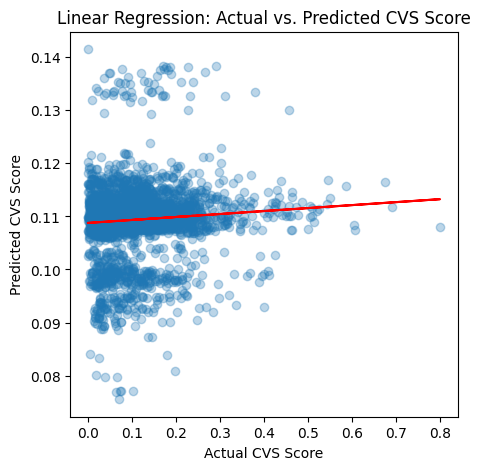

In [40]:
plot_linear_regression_results(Y_train, y_lr_train_pred)


In [41]:
def plot_RF_results(Y_train, y_rf_train_pred):
    plt.figure(figsize=(5, 5))
    plt.scatter(x=Y_train, y=y_rf_train_pred, alpha=0.3)
    z = np.polyfit(Y_train, y_rf_train_pred, 1)
    p = np.poly1d(z)
    plt.plot(Y_train, p(Y_train), color='red')
    plt.xlabel('Actual CVS Score')
    plt.ylabel('Predicted CVS Score')
    plt.title('Random Forest: Actual vs. Predicted CVS Score')
    plt.show()

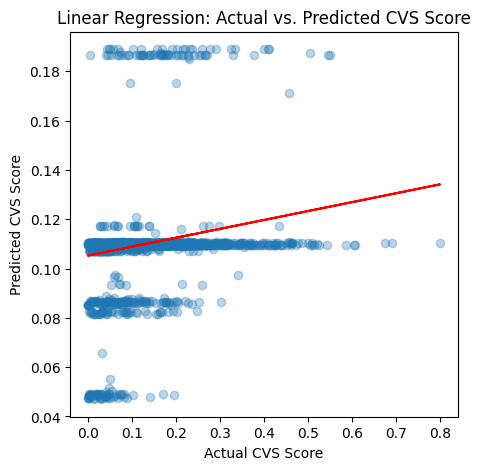

In [42]:
plot_linear_regression_results(Y_train, y_rf_train_pred)

In [43]:
rf_train_mse = mean_squared_error(Y_train, y_lr_train_pred)
rf_train_r2 = r2_score(Y_train, y_lr_train_pred)

rf_test_mse = mean_squared_error(Y_test, y_lr_test_pred)
rf_test_r2 = r2_score(Y_test, y_lr_test_pred)

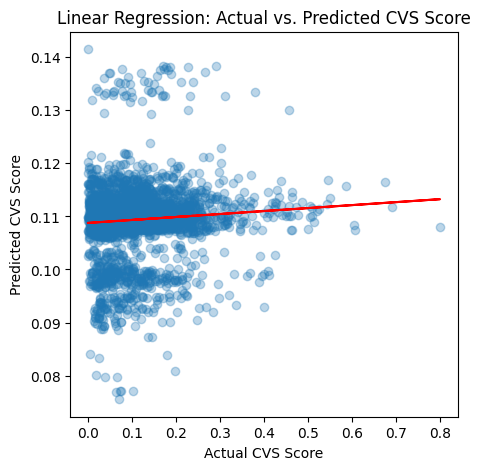

In [44]:
plt.figure(figsize=(5,5))
plt.scatter(x=Y_train, y=y_lr_train_pred, alpha=0.3)
z = np.polyfit(Y_train, y_lr_train_pred, 1)
p = np.poly1d(z)
plt.plot(Y_train, p(Y_train), color='red')
plt.xlabel('Actual CVS Score')
plt.ylabel('Predicted CVS Score')
plt.title('Linear Regression: Actual vs. Predicted CVS Score')
plt.show()

### Function for SHAP Waterfall chart :

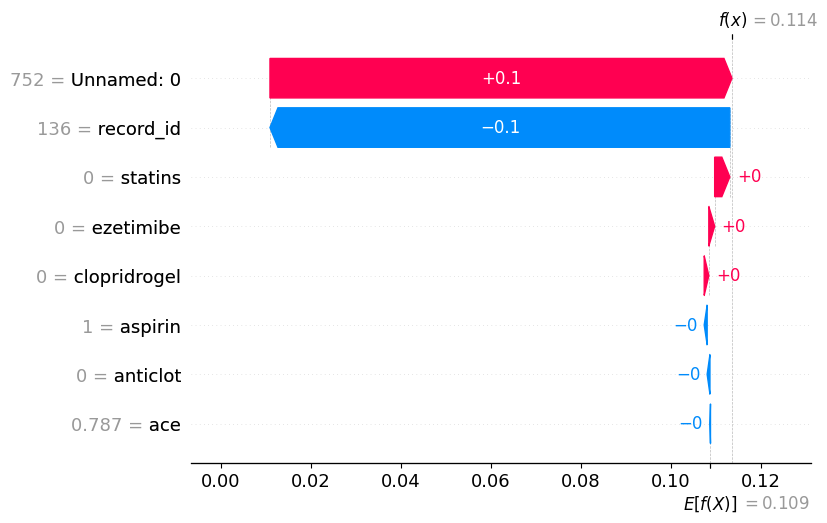

In [45]:
feature_names = x.columns.tolist()
# Create a SHAP explainer
explainer = shap.Explainer(lr, X_test, feature_names=feature_names)

# Calculate SHAP values
shap_values = explainer(X_test)

sample_ind = 14
# Create a SHAP waterfall chart for a specific instance (you can change the index as needed)
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [46]:
# Initialize empty lists for positive and negative SHAP values
positive_shap = []
negative_shap = []

# Iterate through the SHAP values and split them
for value in shap_values:
    if np.any(value.values >= 0):
        positive_shap.append(value.values)
    else:
        negative_shap.append(value.values)

# Print positive SHAP values
print("Positive SHAP Values:")
print(positive_shap)

# Print negative SHAP values
print("Negative SHAP Values:")
print(negative_shap)

Positive SHAP Values:
[array([-0.00634123,  0.00570775,  0.00411094, -0.01605651, -0.00062001,
        0.00129901, -0.00078976,  0.00265061]), array([-0.14831789,  0.14949246, -0.00065557,  0.00102488, -0.00062001,
        0.00129901,  0.00336688, -0.01036546]), array([ 0.07231028, -0.07262582,  0.00021947,  0.00102488, -0.00062001,
        0.00129901, -0.00078976, -0.00011948]), array([ 0.10573519, -0.10503971, -0.00065557,  0.00102488, -0.00062001,
        0.00129901,  0.00336688,  0.00265061]), array([ 0.05211276, -0.05309437, -0.00065557,  0.00102488, -0.00062001,
        0.00129901, -0.00078976, -0.00011948]), array([-0.05715184,  0.05619862,  0.00021947, -0.01605651, -0.00062001,
        0.00129901, -0.00078976, -0.00011948]), array([-0.05980524,  0.05848422,  0.00021947,  0.00102488, -0.00062001,
        0.00129901, -0.00078976,  0.00265061]), array([-0.1111307 ,  0.11126069,  0.00411094,  0.00102488, -0.00062001,
        0.00129901, -0.00078976,  0.00265061]), array([ 0.0184106

#Important Stuff for Listing between positive and negative :

In [47]:
# Initialize empty lists for positive and negative feature names
positive_feature_names = []
negative_feature_names = []

# Iterate through the SHAP values and split them
for i, value in enumerate(shap_values):
    if i < len(feature_names):  # Ensure that the index is within the bounds of feature_names
        feature_name = feature_names[i]  # Get the feature name from the corresponding index

        if any(value.values > 0):  # Check if any value in the Explanation is positive
            positive_feature_names.append(feature_name)
        elif any(value.values < 0):  # Check if any value in the Explanation is negative
            negative_feature_names.append(feature_name)

# Print positive feature names
print("Positive Feature Names:")
print(positive_feature_names)

# Print negative feature names
print("Negative Feature Names:")
print(negative_feature_names)


Positive Feature Names:
['Unnamed: 0', 'record_id', 'aspirin', 'clopridrogel', 'anticlot', 'ezetimibe', 'statins', 'ace']
Negative Feature Names:
[]


In [48]:
def split_shap_values(shap_values, feature_names):
    # Initialize empty lists for positive and negative feature names
    positive_feature_names = []
    negative_feature_names = []

    # Iterate through the SHAP values and split them
    for i, value in enumerate(shap_values):
        if i < len(feature_names):  # Ensure that the index is within the bounds of feature_names
            feature_name = feature_names[i]  # Get the feature name from the corresponding index

            if any(value.values > 0):  # Check if any value in the Explanation is positive
                positive_feature_names.append(feature_name)
            elif any(value.values < 0):  # Check if any value in the Explanation is negative
                negative_feature_names.append(feature_name)

    return positive_feature_names, negative_feature_names

In [49]:
positive_feature_names, negative_feature_names = split_shap_values(shap_values, feature_names)

# Print positive feature names
print("Positive Feature Names:")
print(positive_feature_names)

# Print negative feature names
print("Negative Feature Names:")
print(negative_feature_names)


Positive Feature Names:
['Unnamed: 0', 'record_id', 'aspirin', 'clopridrogel', 'anticlot', 'ezetimibe', 'statins', 'ace']
Negative Feature Names:
[]


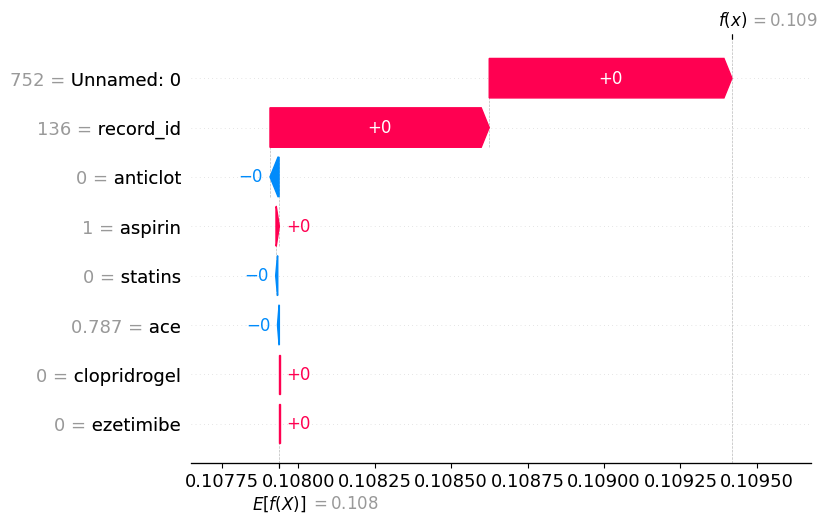

In [50]:
feature_names = x.columns.tolist()
# Create a SHAP explainer
explainer = shap.Explainer(rf, X_test, feature_names=feature_names)

# Calculate SHAP values
shap_values = explainer(X_test)

sample_ind = 14
# Create a SHAP waterfall chart for a specific instance (you can change the index as needed)
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

## NEW SHAP PLOT :

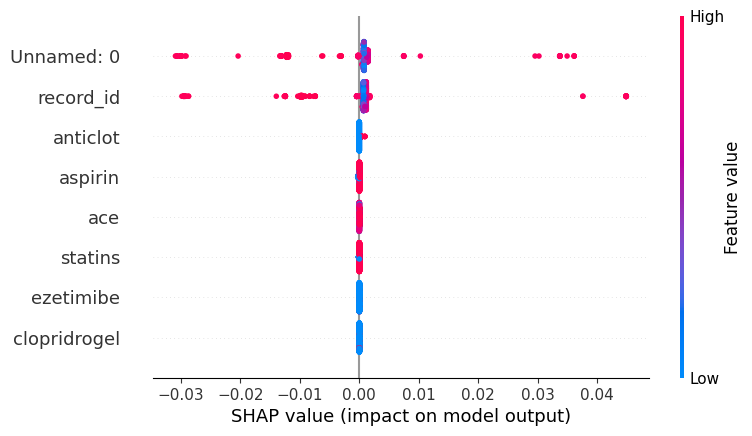

In [51]:
shap.plots.beeswarm(shap_values, max_display=20)

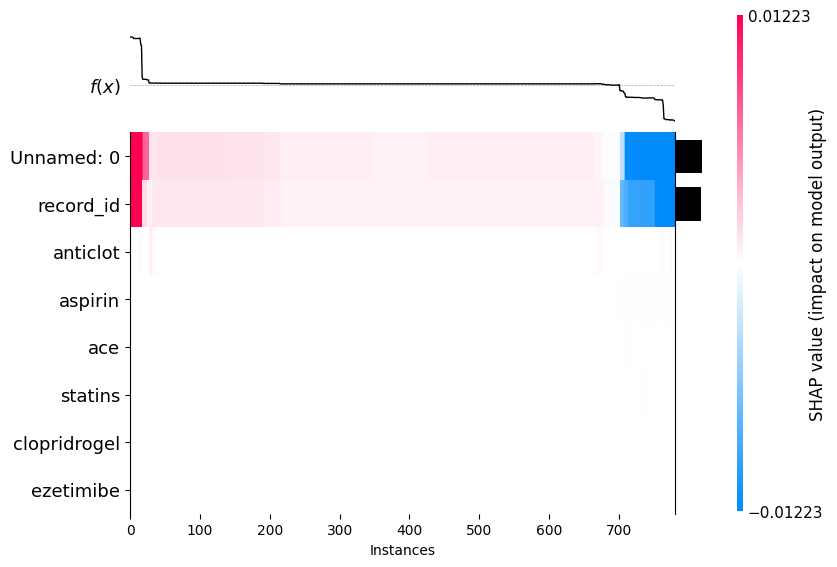

In [52]:
shap.plots.heatmap(shap_values)

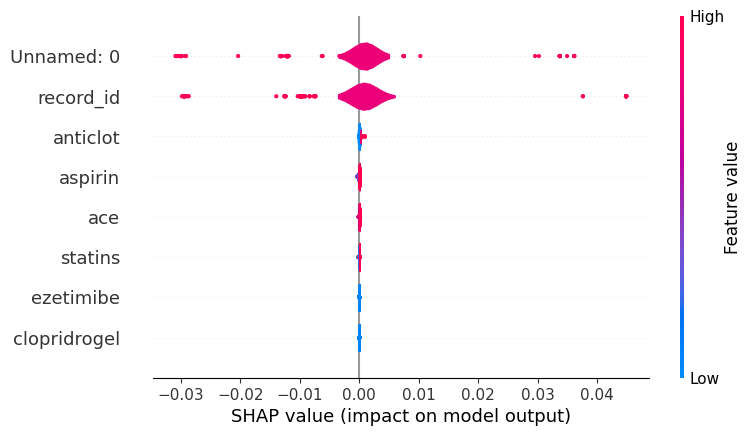

In [53]:
shap.plots.violin(shap_values)

In [54]:
import tempfile
import matplotlib.pyplot as plt

def create_and_display_graph():
    # Create a sample plot
    plt.figure(figsize=(8, 6))
    x = [1, 2, 3, 4, 5]
    y = [10, 15, 13, 18, 20]
    plt.plot(x, y, marker='o')
    plt.title('Sample Plot')
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    
    # Create a temporary directory
    temp_dir = tempfile.mkdtemp()
    
    # Define the path for the saved image
    image_path = f"{temp_dir}/sample_plot.png"
    
    # Save the plot as an image
    plt.savefig(image_path, bbox_inches="tight")
    
    # Display the plot
    plt.show()
    
    # Close the plot to release resources
    plt.close()


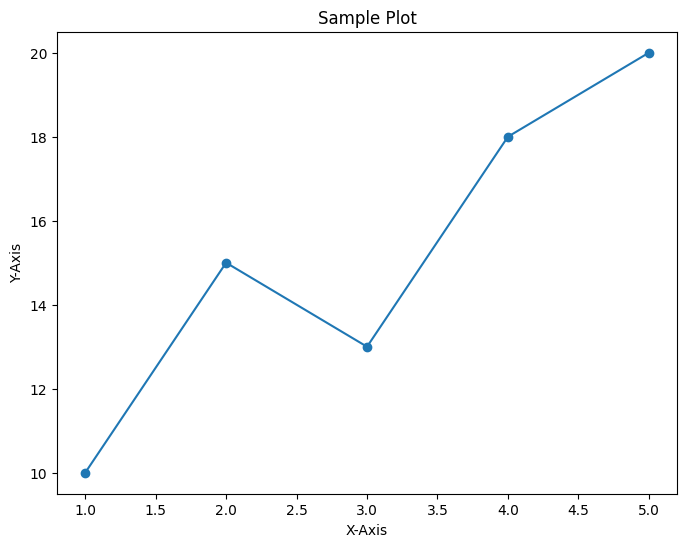

In [55]:
# Call the function to create and save the graph
create_and_display_graph()

In [56]:

def create_shap_waterfall_chart(model, x, X_test, sample_index, max_display=14):
    # Get feature names from the DataFrame
    feature_names = x.columns.tolist()
    
    # Create a SHAP explainer
    explainer = shap.Explainer(model, X_test, feature_names=feature_names)
    
    # Calculate SHAP values
    shap_values = explainer(X_test)
    
    # Create a SHAP waterfall chart for a specific instance
    shap.plots.waterfall(shap_values[sample_index], max_display=max_display)

In [57]:
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns

def create_and_display_graph_test():
    x, y = data_separation(treat)
    x = pd.DataFrame(x)
    x = x.fillna(0)
    x = x.dropna()
    X_train, X_test, Y_train, Y_test = data_split(x, y)
    lr, y_lr_train_pred, y_lr_test_pred = LR(X_train, X_test, Y_train)
    
    z = np.polyfit(Y_train, y_lr_train_pred, 1)
    p = np.poly1d(z)
    scatter = sns.scatterplot(x=Y_train, y=y_lr_train_pred, alpha=0.3)
    plt.plot(Y_train, p(Y_train), color='red', linewidth=2)
    plt.xlabel('Actual CVS Score')
    plt.ylabel('Predicted CVS Score')
    plt.title('Linear Regression: Actual vs. Predicted CVS Score')
    
    # Create a temporary directory
    temp_dir = tempfile.mkdtemp()
    
    # Define the path for the saved image
    image_path = f"{temp_dir}/sample_plot.png"
    
    # Save the plot as an image
    plt.savefig(image_path, bbox_inches="tight")
    
    # Display the plot
    plt.show()
    return image_path
    


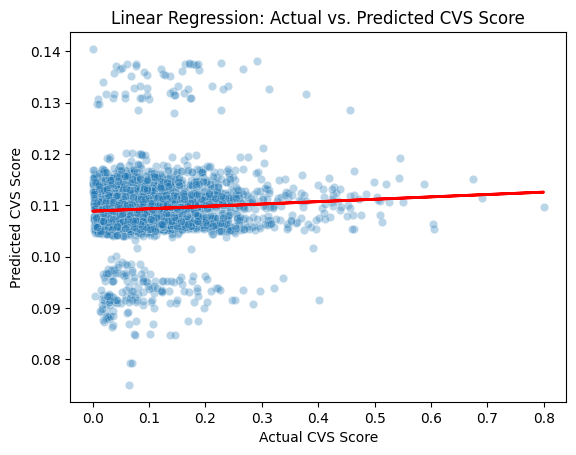

'C:\\Users\\Admin\\AppData\\Local\\Temp\\tmp39gak0jw/sample_plot.png'

In [58]:
create_and_display_graph_test()

In [59]:
import joblib
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif  # Use the appropriate scoring function

def test():
    # Load the pre-trained model
    model = joblib.load('model.joblib')

    # Read the CSV file into a DataFrame in chunks
    chunk_size = 1000  # You can adjust this to an appropriate chunk size
    data_chunks = pd.read_csv('simulated_data.csv', chunksize=chunk_size)

    # Define the number of features to select (304 in your case)
    num_features_to_select = 304

    # Initialize an empty list to store the predictions
    predictions_list = []

    # Loop through data chunks
    for data_chunk in data_chunks:
        # Assuming 'target' is the name of your target variable column
        target = data_chunk['days_from_diag']

        # Select the top 304 features based on the F-statistic score
        selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
        selected_features = selector.fit_transform(data_chunk.drop(columns=['days_from_diag']), target)

        # Get the names of the selected features
        selected_feature_names = data_chunk.drop(columns=['days_from_diag']).columns[selector.get_support()]

        # Create a new DataFrame with the selected features
        selected_data = pd.DataFrame(selected_features, columns=selected_feature_names)

        # Make predictions
        predictions = model.predict(selected_data)

        # Add predictions to the current data chunk
        data_chunk['Predictions'] = predictions

        # Append the current data chunk to the predictions list
        predictions_list.append(data_chunk)

    # Concatenate the predictions list into a single DataFrame
    predictions_df = pd.concat(predictions_list, ignore_index=True)

    # Get the predictions as a list
    predictions_values = predictions_df['Predictions'].tolist()

    # Alternatively, you can return predictions as a NumPy array
    # predictions_values = predictions_df['Predictions'].values

    # Return the list or NumPy array of predictions
    return predictions_values

In [60]:
test()

invalid value encountered in divide
X has feature names, but LogisticRegression was fitted without feature names
invalid value encountered in divide
X has feature names, but LogisticRegression was fitted without feature names
invalid value encountered in divide
X has feature names, but LogisticRegression was fitted without feature names
invalid value encountered in divide
X has feature names, but LogisticRegression was fitted without feature names
invalid value encountered in divide
X has feature names, but LogisticRegression was fitted without feature names
invalid value encountered in divide
X has feature names, but LogisticRegression was fitted without feature names
invalid value encountered in divide
X has feature names, but LogisticRegression was fitted without feature names
invalid value encountered in divide
X has feature names, but LogisticRegression was fitted without feature names
invalid value encountered in divide
X has feature names, but LogisticRegression was fitted witho

[1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,


In [61]:
def create_and_display_graph_with_shap(model, x, X_test, sample_index, Y_train, y_lr_train_pred):
    # Call the Test_SHAP function to generate SHAP plots and get image paths
    bee_swarm_path, violin_path = Test_SHAP(model, x, X_test, sample_index)

    # Create and display the linear regression graph
    z = np.polyfit(Y_train, y_lr_train_pred, 1)
    p = np.poly1d(z)
    scatter = sns.scatterplot(x=Y_train, y=y_lr_train_pred, alpha=0.3)
    plt.plot(Y_train, p(Y_train), color='red', linewidth=2)
    plt.xlabel('Actual CVS Score')
    plt.ylabel('Predicted CVS Score')
    plt.title('Linear Regression: Actual vs. Predicted CVS Score')

    # Save the plot as an image
    temp_dir = tempfile.mkdtemp()
    image_path = f"{temp_dir}/sample_plot.png"
    plt.savefig(image_path, bbox_inches="tight")

    # Display the linear regression plot and SHAP plots
    plt.show()

    # Close the plot to release resources
    plt.close()

    # Return the paths to saved images
    return bee_swarm_path, violin_path, image_path

In [62]:
import joblib
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

# Load the pre-trained model
model = joblib.load('model.joblib')

# Read the CSV file into a DataFrame
data = pd.read_csv('simulated_data.csv')

# Define the number of features to select (304 in your case)
num_features_to_select = 304

In [74]:
def make_predictions_for_patient(selected_row):
    # Extract the selected patient's data
    patient_data = data.iloc[selected_row - 1]  # Assuming selected_row is the row number you want to predict

    # Find the 'days_from_diag' column index
    days_from_diag_idx = patient_data.index.get_loc('side_effect_constip')

    # Extract features starting from 'days_from_diag' and select the next 304 columns
    selected_features = patient_data.iloc[days_from_diag_idx:days_from_diag_idx + num_features_to_select]

    # Create a new DataFrame with the selected features
    selected_data = pd.DataFrame(selected_features).T

    # Make predictions
    prediction = model.predict(selected_data)
    per = round(prediction[0] * 100, 2)

    return f"Prediction for Patient {selected_row}: {prediction[0]} (Percentage: {per:2f}%)"


In [75]:
selected_patient_row = 4  # Replace with the desired patient's row
patient_predictions = make_predictions_for_patient(selected_patient_row)

print(f"Predictions for Patient {selected_patient_row}: {patient_predictions}")

Predictions for Patient 4: Prediction for Patient 4: 1 (Percentage: 100.000000%)


X has feature names, but LogisticRegression was fitted without feature names


In [65]:
#Function for the Joblib Method and to realize predictions for each patients
def Joblib(selected_row):

    # Load the pre-trained model
    model = joblib.load('model.joblib')
    # Read the CSV file into a DataFrame
    data = pd.read_csv('simulated_data.csv')

    # Define the number of features to select (304 in your case)
    num_features_to_select = 304

    patient_data = data.iloc[selected_row - 1]
    target = patient_data.index.get_loc('days_from_diag')
    selected_features = patient_data.iloc[target:target+num_features_to_select]

    selected_data = pd.DataFrame(selected_features).T
    prediction = model.predict(selected_data)

    return prediction[0]

In [66]:
selected_patient_row = 5  # Replace with the desired patient's row
patient_predictions = Joblib(selected_patient_row)

print(f"Predictions for Patient {selected_patient_row}: {patient_predictions}")

Predictions for Patient 5: 1


X has feature names, but LogisticRegression was fitted without feature names


In [67]:
import pandas as pd
# Load the CSV file into a DataFrame
data = pd.read_csv('simulated_data.csv')

# Display the column names and the first few rows
print(data.columns)
print(data.head())

Index(['days_from_diag', 'contact', 'comorb_CKD', 'comorb_COPD', 'comorb_CVA',
       'comorb_diabetes1', 'comorb_infarct', 'comorb_met',
       'comorb_met_local_lung', 'comorb_met_lung',
       ...
       'bl_diag_DC50', 'bl_diag_DC61', 'bl_diag_DC67', 'bl_side_effect_anemia',
       'bl_side_effect_bact_inf', 'bl_side_effect_constip',
       'bl_side_effect_diarrhea', 'bl_side_effect_pain',
       'bl_side_effect_sleep_pb', 'age'],
      dtype='object', length=333)
   days_from_diag  contact  comorb_CKD  comorb_COPD  comorb_CVA  \
0       42.032946      1.0         0.0          1.0         0.0   
1     -303.151054      0.0         0.0          0.0         0.0   
2      708.780687      0.0         0.0          0.0         0.0   
3      127.927063      0.0         0.0          0.0         0.0   
4      641.135051      0.0         0.0          0.0         0.0   

   comorb_diabetes1  comorb_infarct  comorb_met  comorb_met_local_lung  \
0               0.0             0.0         0.0   